<a href="https://colab.research.google.com/github/Nohyunsun/ADHD-Self-Diagnosis-Across-Platforms/blob/main/wordcloud_top50_korean_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 플랫폼별 워드클라우드 (Top-50, 조사 제거, 엑셀 저장)
- 한국어 형태소 분석(**kiwipiepy**)로 조사/어미 제거
- 중복 키워드 없이 **Top-50**만 사용해 워드클라우드 생성
- 플랫폼별 **상위 50 키워드**를 시트로 모아 엑셀 저장

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0) 설치 & 폰트 설정

In [ ]:
!pip -q install kiwipiepy wordcloud openpyxl
!apt -qq -y install fonts-nanum > /dev/null
KOREAN_FONT = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
print("FONT:", KOREAN_FONT)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 58.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 18.6 MB/s eta 0:00:00


FONT: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


## 1) 임포트 & 파라미터

In [ ]:
import re, os
from collections import Counter
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from kiwipiepy import Kiwi

DATA_PATH = "/content/drive/MyDrive/졸업논문/all_mapped.csv"  # 예: "/content/ALL_with_sentiment.csv"
TEXT_COL_PREFER = ["clean_text", "text_norm", "text"]
PLATFORM_COL = "platform"

USER_STOPWORDS = set("""
결과  하루 그냥 조금 너무 진짜 그리고 그러나 그래서 또한 또는 이런 저런 것 것들 등 등등 대해 대한 관련 있음 정도 합니다 합니다요 합니다만 같은 경우 경우엔
경우에는 경우에도 지금 오늘 내일 사람 내가 니가 네가 우리가 여러분 것임 그래도 그래서 그런 그런가 그러면 그러니 이런거 이런것 이번 이번에 자기 본인 정말
사실 약간 매우 너무 또 다시 보다 보니 버리다하다 되다 되었다 했다 하고 한다 하는 중인 대한것 대해 대해서 대해선 있다 없다 아니다 이다 입니다 아닌 아닌데
자가 진단 테스트 초등 가지 필요 다양 우리 마음 때문 성공 리스트 태그 팔로우 시간 해당 이유 탐라 패션 얘기 친구 이거 구독 에이디 내용 블로그 카드 이것 요즘
그거 항복 히나 시작 기습 채널 뇌부자들 안녕 영화 하나 가능 방송 유니 제작 기반 확인 당신 부분 인간 대표 진심 대한민국 그것 무엇 focus your of test nan shorts
my asmr with in to is this the and for you attention instagram adhd it on
""".split())

MIN_LEN = 2
ALLOW_POS_PREFIX = ("N", "SL")  # 명사류/외국어
TOPK = 50

WC_WIDTH, WC_HEIGHT = 1600, 800
BG_COLOR = "white"

OUT_DIR = Path("/content/outputs")
(OUT_DIR/"wordclouds").mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

OUT_DIR: /content/outputs


## 2) 데이터 불러오기 (df 확보)

In [ ]:
def ensure_dataframe():
    if "df" in globals():
        return globals()["df"]
    if "ALL" in globals():
        return globals()["ALL"]
    if DATA_PATH:
        if DATA_PATH.lower().endswith(".xlsx"):
            return pd.read_excel(DATA_PATH)
        else:
            return pd.read_csv(DATA_PATH)
    raise RuntimeError("데이터프레임 df/ALL이 없고 DATA_PATH도 비어 있습니다.")

df = ensure_dataframe()

available_cols = set(df.columns)
text_col = None
for c in TEXT_COL_PREFER:
    if c in available_cols:
        text_col = c; break
if text_col is None:
    for c in df.columns:
        if df[c].dtype == 'object':
            text_col = c; break
assert PLATFORM_COL in available_cols, f"플랫폼 컬럼('{PLATFORM_COL}')이 데이터에 없습니다."
assert text_col is not None, "텍스트 컬럼을 찾지 못했습니다."
print("USING COLUMNS ->", dict(platform=PLATFORM_COL, text=text_col))

df[text_col] = df[text_col].astype(str)

USING COLUMNS -> {'platform': 'platform', 'text': 'text'}


## 3) 전처리 & 토크나이저 (조사/어미 제거)

In [ ]:
import re
URL_RE = re.compile(r"http[s]?://\S+|www\.\S+")
SPACE_RE = re.compile(r"\s+")
NON_KO_EN_NUM = re.compile(r"[^0-9A-Za-z가-힣]+")

kiwi = Kiwi()

def normalize(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = SPACE_RE.sub(" ", s).strip()
    return s

def tokenize_keep_keywords(text: str):
    text = normalize(text)
    out = []
    for token in kiwi.tokenize(text):
        pos = token.tag
        if pos.startswith("J") or pos.startswith("E") or pos in ("SW","SP","SS","SE"):
            continue
        if not pos.startswith(ALLOW_POS_PREFIX):
            continue
        lemma = token.form if token.lemma is None else token.lemma
        lemma = NON_KO_EN_NUM.sub("", lemma)
        if len(lemma) < MIN_LEN: continue
        if lemma.isdigit(): continue
        if lemma in USER_STOPWORDS: continue
        out.append(lemma)
    return out

def build_freq(texts):
    c = Counter()
    for t in texts:
        c.update(tokenize_keep_keywords(t))
    return c

## 4) 플랫폼별 WordCloud 생성 & Top-50 Excel 저장

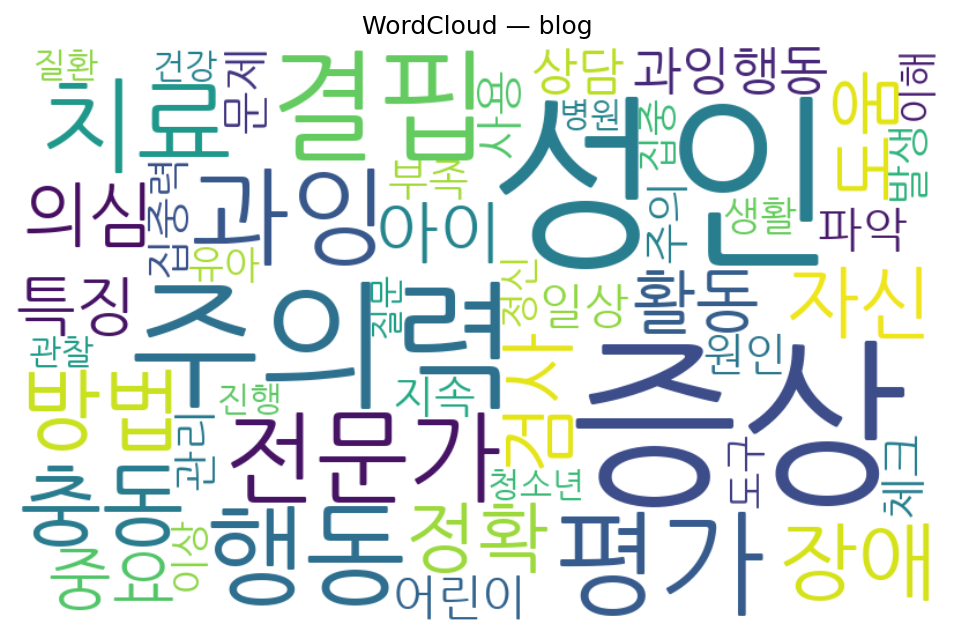

✅ blog: 이미지 저장 -> /content/outputs/wordclouds/wordcloud_blog.png / 시트 저장 -> blog


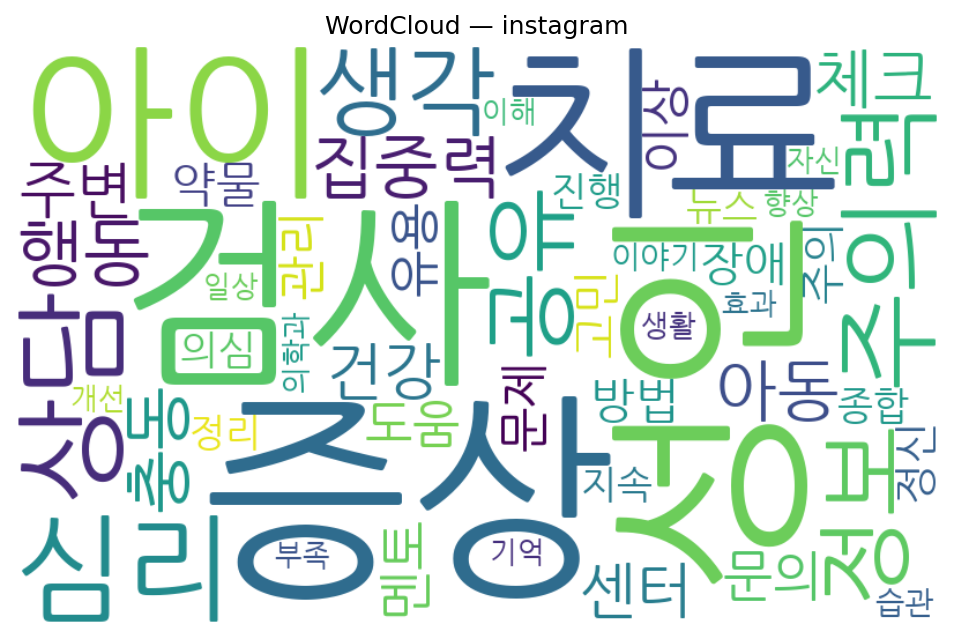

✅ instagram: 이미지 저장 -> /content/outputs/wordclouds/wordcloud_instagram.png / 시트 저장 -> instagram


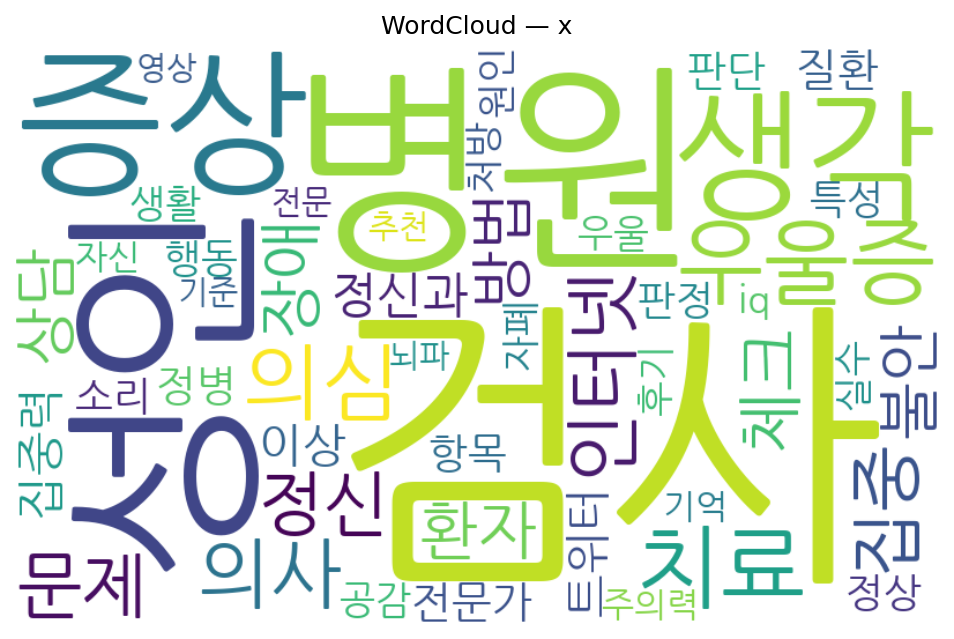

✅ x: 이미지 저장 -> /content/outputs/wordclouds/wordcloud_x.png / 시트 저장 -> x


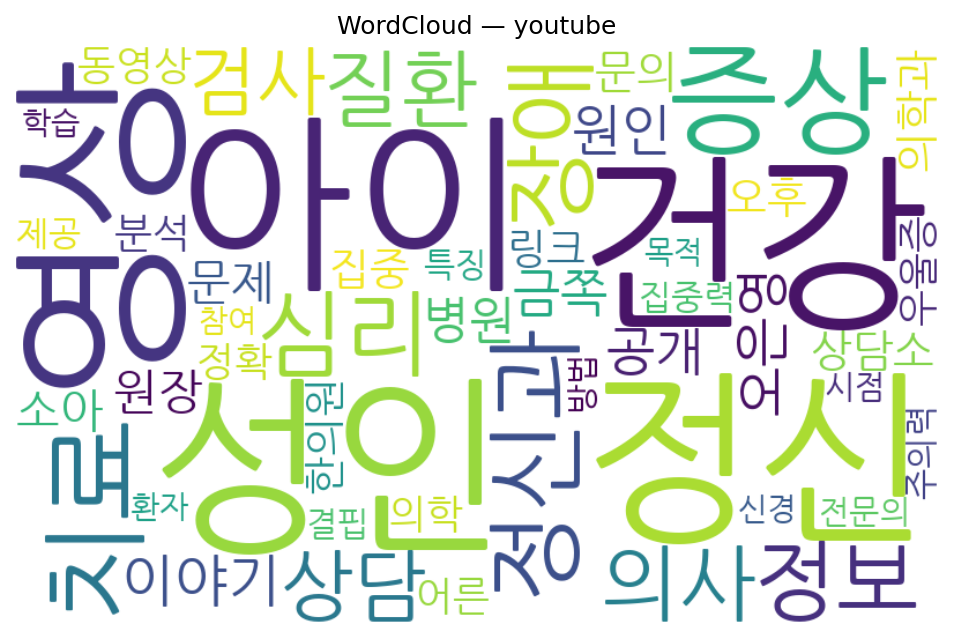

✅ youtube: 이미지 저장 -> /content/outputs/wordclouds/wordcloud_youtube.png / 시트 저장 -> youtube
✔ 모든 작업 완료
이미지 폴더: /content/outputs/wordclouds
엑셀 파일 : /content/outputs/wordcloud_top50.xlsx


In [ ]:
def make_wordcloud_from_freq(freq_dict, title, save_path):
    wc = WordCloud(
        width=800, height=500,          # ✅ 크기 축소 (기존 1200x800 → 800x500)
        background_color=BG_COLOR,
        font_path=KOREAN_FONT,
        max_words=TOPK
    ).generate_from_frequencies(freq_dict)

    plt.figure(figsize=(8,5), dpi=150)  # ✅ 출력창 크기 축소 (기존 1200/160 = 7.5 → 그대로 8x5)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=12)
    plt.savefig(save_path, dpi=160, bbox_inches="tight")
    plt.show()


excel_path = OUT_DIR/"wordcloud_top50.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    for p in sorted(df[PLATFORM_COL].dropna().unique()):
        sub = df[df[PLATFORM_COL]==p]
        texts = sub[text_col].dropna().astype(str).tolist()
        if not texts:
            print(f"⚠️ {p}: 텍스트 없음 → 생략")
            continue

        freq = build_freq(texts)
        if not freq:
            print(f"⚠️ {p}: 키워드 추출 결과 없음 → 생략")
            continue

        top = dict(freq.most_common(TOPK))
        img_path = OUT_DIR/"wordclouds"/f"wordcloud_{p}.png"
        make_wordcloud_from_freq(top, f"WordCloud — {p}", img_path)

        total = sum(freq.values()) or 1
        df_top = pd.DataFrame(list(top.items()), columns=["term","count"])
        df_top.insert(0, "rank", range(1, len(df_top)+1))
        df_top["share(%)"] = (df_top["count"]/total*100).round(2)
        df_top.insert(0, "platform", p)

        import re as _re
        sheet = _re.sub(r"[^A-Za-z0-9가-힣]+","_", str(p))[:31] or "sheet"
        df_top.to_excel(writer, index=False, sheet_name=sheet)
        print(f"✅ {p}: 이미지 저장 -> {img_path} / 시트 저장 -> {sheet}")

print("✔ 모든 작업 완료")
print("이미지 폴더:", OUT_DIR/"wordclouds")
print("엑셀 파일 :", excel_path)